In [1]:
## Add path to sys
import sys
sys.path.append('../../')
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from preprocessing import data_processing
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [3]:
train_dataset = 'D:/Projects/tumai_braintumor_classification/dataset/train/'
test_dataset = 'D:/Projects/tumai_braintumor_classification/dataset/test/'
IMG_SIZE = (224,224)

X_train, y_train, labels = data_processing.load_data_tonumpy(train_dataset, IMG_SIZE)
X_test, y_test, _ = data_processing.load_data_tonumpy(test_dataset, IMG_SIZE)

# apply this for each set
X_train_crop = data_processing.crop_imgs(set_name=X_train)
X_test_crop = data_processing.crop_imgs(set_name=X_test)

100%|██████████| 2/2 [00:00<00:00,  4.10it/s]


202 images loaded from D:/Projects/tumai_braintumor_classification/dataset/train/ directory.


100%|██████████| 2/2 [00:00<00:00, 15.75it/s]


51 images loaded from D:/Projects/tumai_braintumor_classification/dataset/test/ directory.


In [4]:
from keras import layers
from keras.applications.vgg16 import preprocess_input
from keras.models import Model, Sequential
from matplotlib import pyplot 
from numpy import expand_dims

In [5]:
def preprocess_for_vgg(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        # set_new.append(preprocess_input(img))
        set_new.append(img/255)
    return np.array(set_new)

In [6]:
X_train_prep = preprocess_for_vgg(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_for_vgg(set_name=X_test_crop, img_size=IMG_SIZE)

## GALA Network

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [13]:
## Write the model code in a non sequential pattern
inputs = keras.Input(shape=(224, 224, 3))
x = layers.Conv2D(filters=32, kernel_size=5, activation=None, padding='same')(inputs)
# x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
# x = squeeze_excite_block(filters=32, inputs=x)
x = layers.MaxPool2D(2)(x)

x = layers.Conv2D(filters=64, kernel_size=3, activation=None, padding='same')(x)
# x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
# x = squeeze_excite_block(filters=64, inputs=x)
x = layers.MaxPool2D(2)(x)

x = layers.Conv2D(filters=128, kernel_size=3, activation=None, padding='same')(x)
# x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
# x = squeeze_excite_block(filters=128, inputs=x)
x = layers.MaxPool2D(2)(x)

x = layers.Conv2D(filters=256, kernel_size=3, activation=None, padding='same')(x)
# x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
# x = squeeze_excite_block(filters=256, inputs=x)
x = layers.MaxPool2D(2)(x)

x = layers.Conv2D(filters=512, kernel_size=3, activation=None, padding='same')(x)
# x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPool2D(2)(x)

x = layers.MultiHeadAttention(num_heads=8, key_dim=512, dropout=0.1)(x, x)

## Single SnE
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)


model = keras.Model(inputs=inputs, outputs=outputs, name="SelfAttention")
model.summary()

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)



Model: "SelfAttention"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_10 (Conv2D)             (None, 224, 224, 32  2432        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 activation_10 (Activation)     (None, 224, 224, 32  0           ['conv2d_10[0][0]']              
                                )                                                     

In [16]:
## Early stopping
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    # monitor='val_accuracy',
    monitor='val_loss',
    patience=3,
    verbose=1,
    restore_best_weights=True
)

model.fit(
    X_train_prep,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_prep, y_test),
    callbacks=[early_stopping]
)

Epoch 1/100
7/7 [==============================] - 12s 2s/step - loss: 0.6156 - accuracy: 0.6040 - val_loss: 0.6054 - val_accuracy: 0.6863
Epoch 2/100
7/7 [==============================] - 12s 2s/step - loss: 0.6022 - accuracy: 0.6139 - val_loss: 0.5848 - val_accuracy: 0.6471
Epoch 3/100
7/7 [==============================] - 12s 2s/step - loss: 0.6019 - accuracy: 0.6584 - val_loss: 0.5647 - val_accuracy: 0.7059
Epoch 4/100
7/7 [==============================] - 12s 2s/step - loss: 0.5828 - accuracy: 0.6832 - val_loss: 0.5547 - val_accuracy: 0.6667
Epoch 5/100
7/7 [==============================] - 12s 2s/step - loss: 0.5709 - accuracy: 0.6881 - val_loss: 0.5550 - val_accuracy: 0.6863
Epoch 6/100
7/7 [==============================] - 13s 2s/step - loss: 0.5564 - accuracy: 0.7030 - val_loss: 0.5076 - val_accuracy: 0.7255
Epoch 7/100
7/7 [==============================] - 12s 2s/step - loss: 0.5337 - accuracy: 0.7129 - val_loss: 0.5854 - val_accuracy: 0.6275
Epoch 8/100
7/7 [==========

In [12]:
model.evaluate(X_test_prep, y_test)

2/2 [==============================] - 1s 287ms/step - loss: 0.3110 - accuracy: 0.9216


[0.311045378446579, 0.9215686321258545]

In [13]:
from sklearn.metrics import f1_score, confusion_matrix

y_pred = model.predict(X_test_prep)
y_pred = np.where(y_pred > 0.5, 1, 0)

f1_score(y_test, y_pred)
confusion_matrix(y_test, y_pred)

2/2 [==============================] - 1s 283ms/step


array([[18,  2],
       [ 2, 29]], dtype=int64)

In [14]:
## Get all X_test and y_test with wrong prediction

X_test_wrong = X_test_prep[y_test != y_pred.reshape(-1)]
y_test_wrong = y_test[y_test != y_pred.reshape(-1)]

X_test_right = X_test_prep[y_test == y_pred.reshape(-1)]
y_test_right = y_test[y_test == y_pred.reshape(-1)]

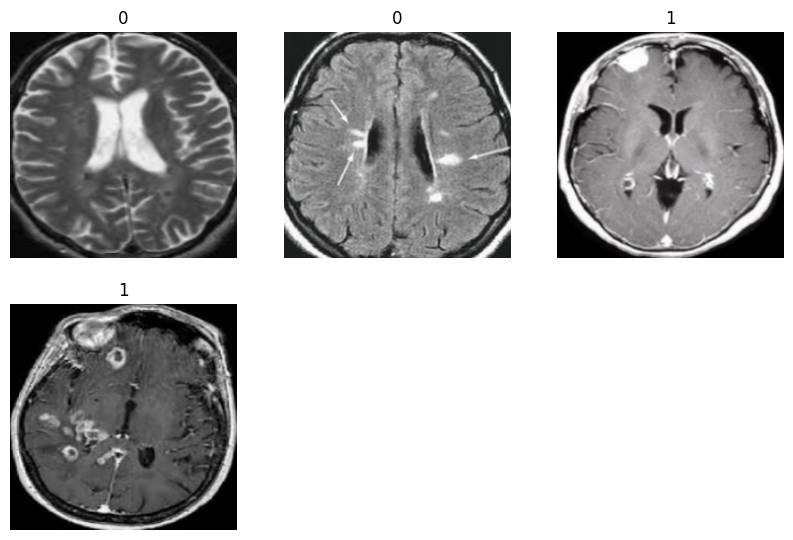

In [15]:
## Plot all wrong prediction

plt.figure(figsize=(10, 10))
for i in range(len(X_test_wrong)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(X_test_wrong[i], cmap='gray')
    plt.title(str(y_test_wrong[i]))
    plt.axis("off")

plt.show()

In [16]:
import shap
explainer = shap.DeepExplainer(model, data=X_test_prep)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [22]:
# ## Using SHAP to explain the model
# import shap
# # Create an explainer object
# for i in range(len(X_test_wrong)):
#     # Get a sample the wrong prediction
#     sample = X_test_wrong[i].reshape(1, 224, 224, 3)
#     # Get the shap values
#     shap_values = explainer.shap_values(sample)
#     # Plot the shap values
#     ## Add the original and probability of the wrong prediction
#     shap.image_plot(shap_values, sample, show=False)
#     plt.title('Original: ' + str(y_test_wrong[i]))
#     plt.show()

## SHAP explanations

In [ ]:
def prediction_function(images):
     return model.predict(images, verbose=False)

100%|██████████| 1000/1000 [00:25<00:00, 38.58it/s]


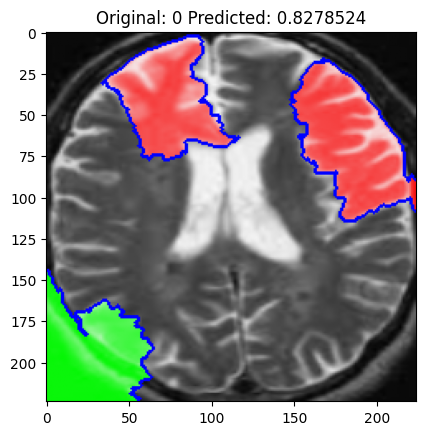

100%|██████████| 1000/1000 [00:24<00:00, 40.51it/s]


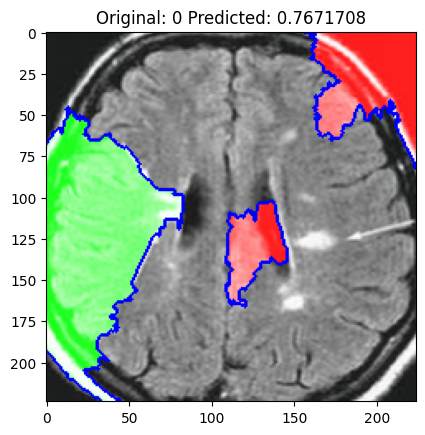

100%|██████████| 1000/1000 [00:31<00:00, 31.29it/s]


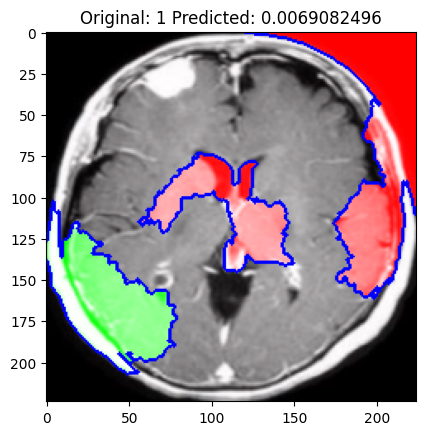

100%|██████████| 1000/1000 [01:04<00:00, 15.44it/s]


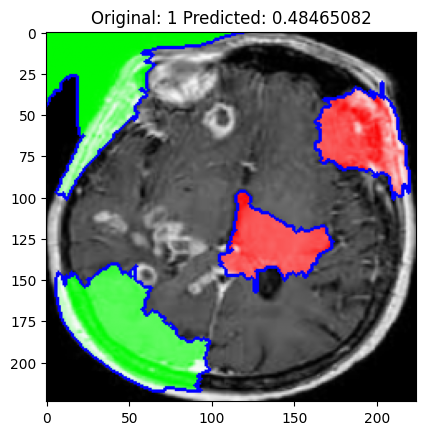

In [83]:
from skimage.segmentation import mark_boundaries
from lime import lime_image

for i in range(len(X_test_wrong)):
     explainer = lime_image.LimeImageExplainer(random_state=42, verbose=False)
     explanation = explainer.explain_instance(
          X_test_wrong[i],
          prediction_function,
          num_samples=1000         
     )

     plt.title('Original: ' + str(y_test_wrong[i]) + ' Predicted: ' + str(model.predict(X_test_wrong[i].reshape(1, 224, 224, 3), verbose=False)[0][0]))
     plt.imshow(X_test_wrong[i])
     image, mask = explanation.get_image_and_mask(
          model.predict(
               X_test_wrong[0].reshape(1, 224, 224, 3), verbose=False
          ).argmax(axis=1)[0],
          positive_only=False,
          negative_only=False,
          hide_rest=False
     )
     plt.imshow(mark_boundaries(image, mask, color=(0, 0, 1), mode='thick'))
     plt.show()

100%|██████████| 50/50 [00:05<00:00,  9.97it/s]


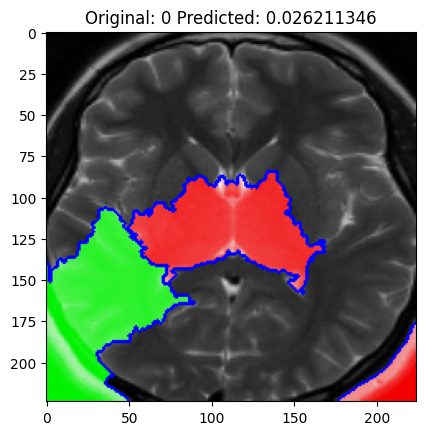

100%|██████████| 50/50 [00:03<00:00, 12.86it/s]


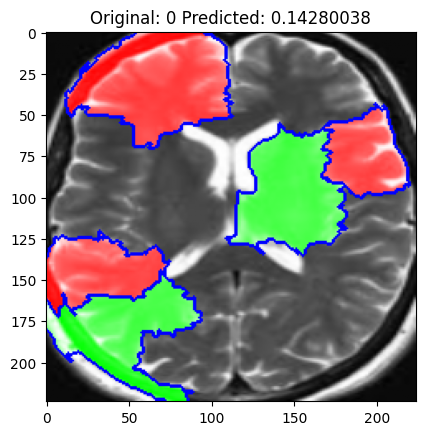

100%|██████████| 50/50 [00:05<00:00,  9.93it/s]


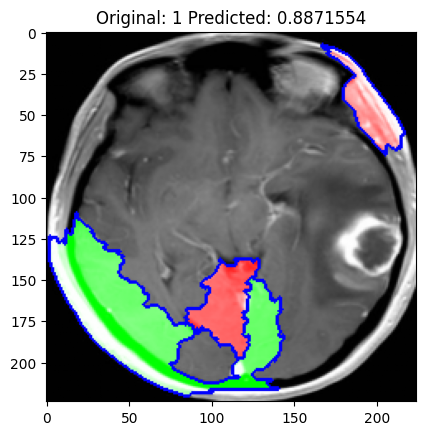

100%|██████████| 50/50 [00:03<00:00, 13.47it/s]


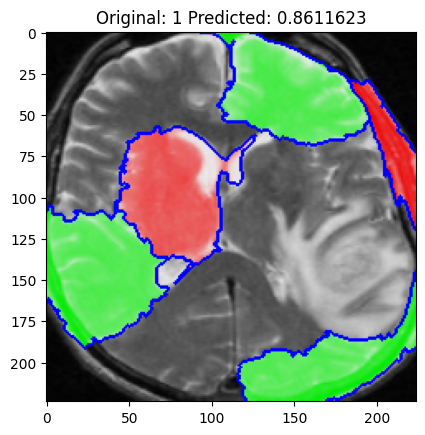

100%|██████████| 50/50 [00:03<00:00, 12.58it/s]


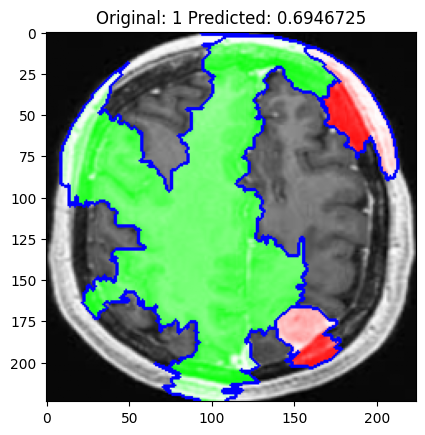

In [85]:
## Write the above code for X_test_right
for i in [0,5,-4,-5,-7]:
    explainer = lime_image.LimeImageExplainer(random_state=42, verbose=False)
    explanation = explainer.explain_instance(
        X_test_right[i],
        prediction_function,
        num_samples=50         
    )

    plt.title('Original: ' + str(y_test_right[i]) + ' Predicted: ' + str(model.predict(X_test_right[i].reshape(1, 224, 224, 3), verbose=False)[0][0]))
    plt.imshow(X_test_right[i])
    image, mask = explanation.get_image_and_mask(
        model.predict(
            X_test_right[0].reshape(1, 224, 224, 3), verbose=False
        ).argmax(axis=1)[0],
        positive_only=False,
        negative_only=False,
        hide_rest=False
    )
    plt.imshow(mark_boundaries(image, mask, color=(0, 0, 1), mode='thick'))
    plt.show()
